# Goal

Nyul-Udupa histogram rescaling

# Imports

In [26]:
import os

# Paths to (1) code (2) data (3) saved models
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata"
model_src   = "/gpfs/data/oermannlab/private_data/DeepPit/saved_models"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"
label_src   = f"{data_src}/samir_labels"
ABIDE_src   = f"{data_src}/ABIDE"

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in data src: ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, AIBL, test.txt, CPTAC-GBM, ABIDE-ABIDE-top.txt, TCGA-GBM, TCGA-LGG, ABVIB, ABIDE, AIBL.zip
Folders in label src (data w labels): 50155-50212, 50313-50372, 50213-50312, 50373-50453, 50002-50153
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


In [27]:
from fastai.vision.core import *

In [28]:
class RandTransform(DisplayedTransform):
    "A transform that before_call its state at each `__call__`"
    do,nm,supports,split_idx = True,None,[],0
    def __init__(self, p=1., nm=None, before_call=None, **kwargs):
        store_attr('p')
        super().__init__(**kwargs)
        self.before_call = ifnone(before_call,self.before_call)

    def before_call(self, b, split_idx):
        "Set `self.do` based on `self.p`"
        self.do = self.p==1. or random.random() < self.p

    def __call__(self, b, split_idx=None, **kwargs):
        self.before_call(b, split_idx=split_idx)
        return super().__call__(b, split_idx=split_idx, **kwargs) if self.do else b

In [29]:
# imports
from transforms import AddChannel, Iso, PadSz

# Utilities
import os
import sys
import time
import pickle
from pathlib import Path

# regex
from re import search

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai import *
from fastai.torch_basics import *
from fastai.basics import *
from fastai.distributed import *

# PyTorch
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils import *
from models import obelisk_visceral, obeliskhybrid_visceral

# 3D extension to FastAI
# from faimed3d.all import *

# Helper functions
from helpers.preprocess import get_data_dict, paths2objs, folder2objs, seg2mask, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups
from helpers.viz import viz_axis

# Transform

## from FAIMED3D 02_preprocessing

In [30]:
# from FAIMED3D 02_preprocessing

Piecewise linear histogram matching
[1] N. Laszlo G and J. K. Udupa, “On Standardizing the MR Image Intensity Scale,” Magn. Reson. Med., vol. 42, pp. 1072–1081, 1999.

[2] M. Shah, Y. Xiao, N. Subbanna, S. Francis, D. L. Arnold, D. L. Collins, and T. Arbel, “Evaluating intensity normalization on MRIs of human brain with multiple sclerosis,” Med. Image Anal., vol. 15, no. 2, pp. 267–282, 2011.

Implementation adapted from: https://github.com/jcreinhold/intensity-normalization, ported to pytorch (no use of numpy works in cuda).

In contrast to hist_scaled, the piecewise linear histogram matching need pre-specified values for new scale and landmarks. It should be used to normalize a whole dataset.

In [31]:
def get_percentile(t, q):
    """
    Return the ``q``-th percentile of the flattened input tensor's data.

    CAUTION:
     * Needs PyTorch >= 1.1.0, as ``torch.kthvalue()`` is used.
     * Values are not interpolated, which corresponds to
       ``numpy.percentile(..., interpolation="nearest")``.

    :param t: Input tensor.
    :param q: Percentile to compute, which must be between 0 and 100 inclusive.
    :return: Resulting value (float).

    This function is twice as fast as torch.quantile and has no size limitations
    """
    # Note that ``kthvalue()`` works one-based, i.e. the first sorted value
    # indeed corresponds to k=1, not k=0! Use float(q) instead of q directly,
    # so that ``round()`` returns an integer, even if q is a np.float32.

    k = 1 + round(.01 * float(q) * (t.numel() - 1))
    result = t.view(-1).kthvalue(k)[0].item()

    return result

In [32]:
def get_landmarks(t: torch.Tensor, percentiles: torch.Tensor)->torch.Tensor:
    """
    Returns the input's landmarks.

    :param t (torch.Tensor): Input tensor.
    :param percentiles (torch.Tensor): Peraentiles to calculate landmarks for.
    :return: Resulting landmarks (torch.tensor).
    """
    return tensor([get_percentile(t, perc.item()) for perc in percentiles])

In [33]:
def find_standard_scale(inputs, i_min=1, i_max=99, i_s_min=1, i_s_max=100, l_percentile=10, u_percentile=90, step=10):
    """
    determine the standard scale for the set of images
    Args:
        inputs (list or L): set of TensorDicom3D objects which are to be normalized
        i_min (float): minimum percentile to consider in the images
        i_max (float): maximum percentile to consider in the images
        i_s_min (float): minimum percentile on the standard scale
        i_s_max (float): maximum percentile on the standard scale
        l_percentile (int): middle percentile lower bound (e.g., for deciles 10)
        u_percentile (int): middle percentile upper bound (e.g., for deciles 90)
        step (int): step for middle percentiles (e.g., for deciles 10)
    Returns:
        standard_scale (np.ndarray): average landmark intensity for images
        percs (np.ndarray): array of all percentiles used
    """
    percs = torch.cat([torch.tensor([i_min]),
                       torch.arange(l_percentile, u_percentile+1, step),
                       torch.tensor([i_max])], dim=0)
    standard_scale = torch.zeros(len(percs))

    for input_image in inputs:
        mask_data = input_image > input_image.mean()
        masked = input_image[mask_data]
        landmarks = get_landmarks(masked, percs)
        min_p = get_percentile(masked, i_min)
        max_p = get_percentile(masked, i_max)
        new_landmarks = landmarks.interp_1d(torch.FloatTensor([i_s_min, i_s_max]),
                                            torch.FloatTensor([min_p, max_p]))
        standard_scale += new_landmarks
    standard_scale = standard_scale / len(inputs)
    return standard_scale, percs

In [44]:
@patch
def piecewise_hist(image:torch.Tensor, landmark_percs, standard_scale)->torch.Tensor:
    """
    Do the Nyul and Udupa histogram normalization routine with a given set of learned landmarks

    Args:
        input_image (TensorDicom3D): image on which to find landmarks
        landmark_percs (torch.tensor): corresponding landmark points of standard scale
        standard_scale (torch.tensor): landmarks on the standard scale
    Returns:
        normalized (TensorDicom3D): normalized image
    """
    mask_data = image > image.mean()
    masked = image[mask_data]
    landmarks = get_landmarks(masked, landmark_percs)
    if landmarks.device != image.device: landmarks = landmarks.to(image.device)
    if standard_scale.device != image.device: standard_scale = standard_scale.to(image.device)
    return image.flatten().interp_1d(landmarks, standard_scale).reshape(image.shape)

In [42]:
class PiecewiseHistScaling(RandTransform):
    """
    Applies theNyul and Udupa histogram nomalization and rescales the pixel values.

    Args:
        input_image (TensorDicom3D): image on which to find landmarks
        landmark_percs (torch.tensor): corresponding landmark points of standard scale
        final_scale (function): final rescaling of values, if none is provided values are
                                scaled to a mean of 0 and a std of 1.
        slicewise (bool): if the scaling should be applied to each slice individually. Slower but leads to more homogeneous images.

    Returns:
        If input is TensorMask3D returns input unchanged
        If input is TensorDicom3D returns normalized and rescaled Tensor

    """
    split_idx,order = None, 10
    def __init__(self, landmark_percs=None, standard_scale=None, final_scale=None, p=1., slicewise=False, slice_dim=None, **kwargs):
        super().__init__(p, **kwargs)
        store_attr()

    def encodes(self, x):
        #x,mk = x
        if self.landmark_percs is None or self.standard_scale is None:
            self.standard_scale, self.landmark_percs = find_standard_scale(x)
        if self.slicewise:
            if self.slice_dim is None: self.slice_dim = 0
            x = torch.stack([s.piecewise_hist(self.landmark_percs, self.standard_scale) for s in torch.unbind(x, self.slice_dim)], self.slice_dim)
        else: x = x.piecewise_hist(self.landmark_percs, self.standard_scale)
        x = x.clamp(min=0)
        x = x.sqrt().max_scale() if self.final_scale is None else self.final_scale(x)
        return x
        #return x, mk

# MR data

In [36]:
def get_data_dict_n4(train_path):
    train_folders   = os.listdir(train_path)
    train_data_dict = {}
    for folder in train_folders:
        segm_obj_path = os.path.join(train_path, folder, "seg.pt")

        mp_path      = os.path.join(train_path, folder, "MP-RAGE")
        folder1_path = os.path.join(mp_path, os.listdir(mp_path)[0])
        folder2_path = os.path.join(folder1_path, os.listdir(folder1_path)[0])

        # choose corrected_n4 if available
        nii_paths = glob.glob(f"{folder2_path}/*.nii")
        nii_path = nii_paths[0]
         
        if len(nii_paths) > 1 and not nii_path.endswith("corrected_n4.nii"):
            nii_path = nii_paths[1]
            
        train_data_dict[folder] = (nii_path, segm_obj_path) #(segm_obj_path, nii_path)
    return train_data_dict

In [37]:
# Get data dict
data = {}
folders = os.listdir(label_src)
for folder in folders: 
    data.update(get_data_dict_n4(f"{label_src}/{folder}"))

# Convert data dict => items (path to MR, path to Segm tensor)
items = list(data.values())

In [38]:
items_n4 = [item for item in items if item[0].endswith("corrected_n4.nii")]
print(len(items_n4))

69


In [39]:
def path2tensor(mr_path):
    mr = sitk.ReadImage(mr_path, sitk.sitkFloat32)
    return torch.transpose(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)

images = L(path2tensor(mr_path) for mr_path, seg_path in items_n4)

In [47]:
@patch
def max_scale(t:torch.Tensor):
    t = (t - t.min()) / (t.max() - t.min())
    return t

# Process

In [40]:
start = time.time()
standard_scale, percs = find_standard_scale(images)
elapsed = time.time() - start
print(f"Elapsed {elapsed} s for {len(images)} tensor images.")

print(standard_scale, percs)

Elapsed 119.54793977737427 s for 69 tensor images.
tensor([ 8707.2285, 13687.5439, 18699.1270, 22679.2188, 26124.3125, 29558.2500,
        33436.2930, 38247.3242, 44183.0547, 51976.0703, 84894.2891]) tensor([ 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99])


In [62]:
f"{deepPit_src}/saved_metadata/nyul_udupa_standard_scale_{len(images)}.pt"

'/gpfs/home/gologr01/DeepPit/saved_metadata/nyul_udupa_standard_scale_69.pt'

In [63]:
# save
save_loc = f"{deepPit_src}/saved_metadata/"
torch.save(standard_scale, f"{save_loc}/nyul_udupa_standard_scale_{len(images)}.pt")
torch.save(percs, f"{save_loc}/nyul_udupa_percs_{len(images)}.pt")

In [48]:
start = time.time()
scaled = L(PiecewiseHistScaling(landmark_percs=percs, 
                                  standard_scale=standard_scale)(im) for im in images)
elapsed = time.time() - start
print(f"Elapsed {elapsed} s for {len(images)} tensor images.")

In [51]:
print(len(images), len(scaled), "len images and scaled")

69 69 len images and scaled


In [52]:
items_n4[:2]

[('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212/50201/MP-RAGE/2000-01-01_00_00_00.0/S164577/ABIDE_50201_MRI_MP-RAGE_br_raw_20120830171150028_S164577_I328580_corrected_n4.nii',
  '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212/50201/seg.pt'),
 ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212/50193/MP-RAGE/2000-01-01_00_00_00.0/S164730/ABIDE_50193_MRI_MP-RAGE_br_raw_20120830181246062_S164730_I328740_corrected_n4.nii',
  '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212/50193/seg.pt')]

In [57]:
# Viz

def viz_compare(idx):

    orig_im, scaled_im  = np.array(images[idx]), np.array(scaled[idx])
    segm_path = items_n4[idx][1]
    mk = np.array(torch.load(segm_path).float())
    
    bbox = mask2bbox(mk)
    print_bbox(*bbox)
    
    # viz
    viz_axis(np_arr = orig_im, \
            bin_mask_arr   = mk,     color1 = "yellow",  alpha1=0.3, \
            slices=lrange(*bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \
             
            np_arr_b = scaled_im, \
            bin_mask_arr_b   = mk,     color1_b = "yellow",  alpha1_b=0.3, \
            slices_b=lrange(*bbox[0:2]), fixed_axis_b=0, \
            title_b = "Axis 0", \
             
        ncols = 5, hspace=0.3, fig_mult=2)


Bbox coords: (69, 143, 106) to (101, 170, 126). Size: 32, 27, 20.
Bounding box coord: from location (143, 106) of slice 69 to location (170, 126) of slice 101.


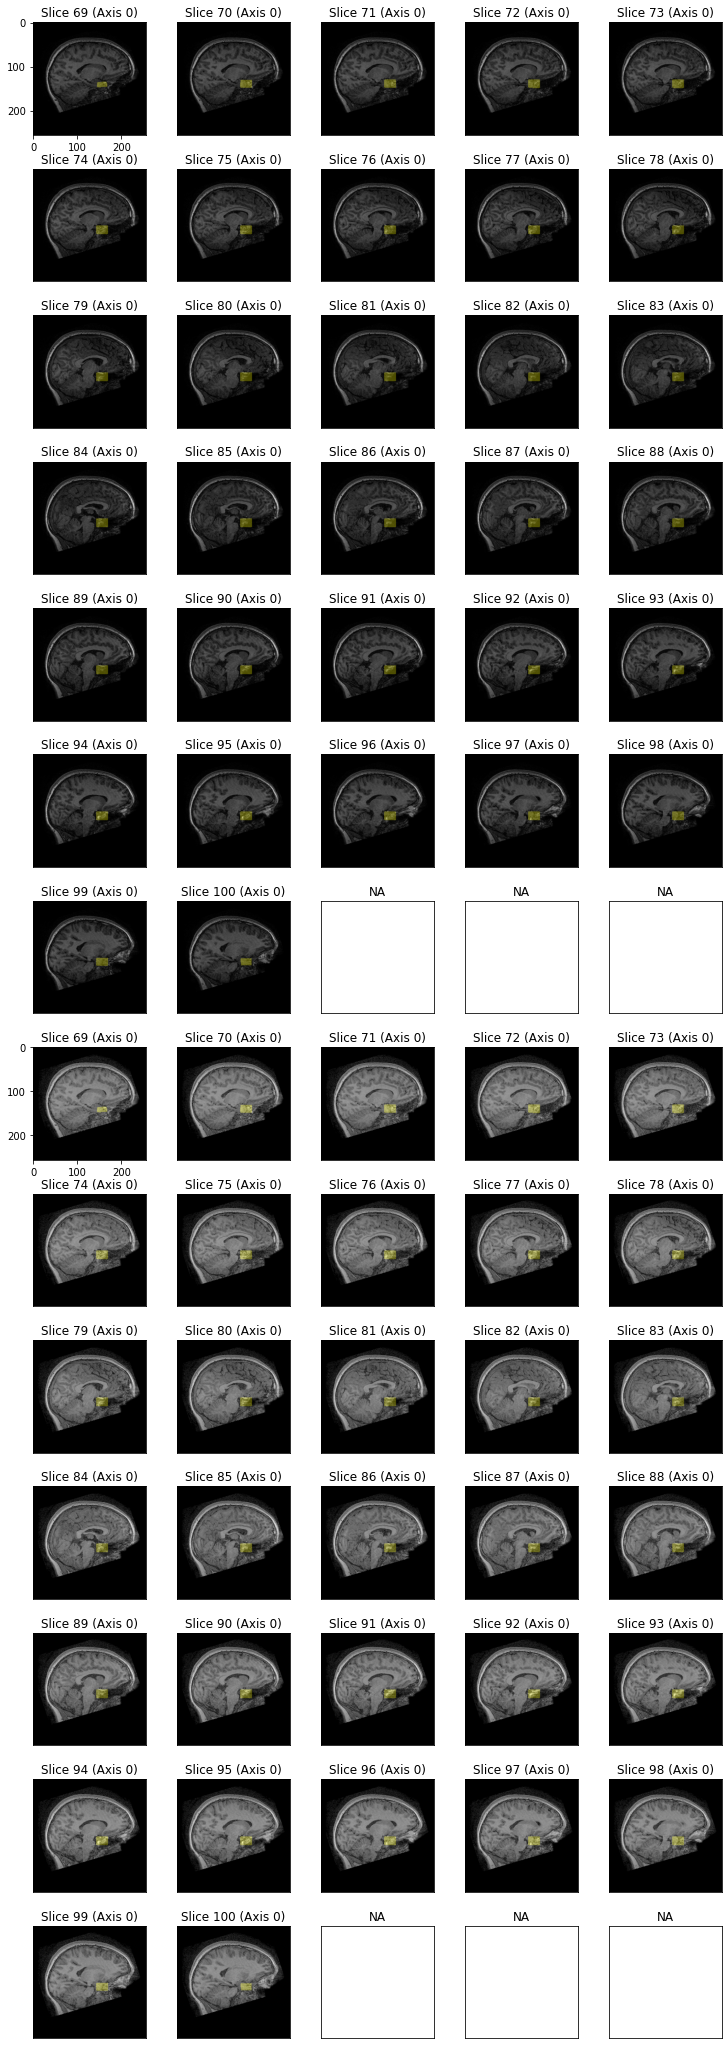

In [58]:
viz_compare(0)